In [1]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import torch
from sklearn.preprocessing import LabelEncoder
from torch.optim import optimizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.nn import CrossEntropyLoss,BCEWithLogitsLoss
from tqdm import tqdm_notebook, trange
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from sklearn.metrics import precision_recall_curve,classification_report
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
SPLIT_RATIO = 0.9   #训练和验证集的比例
#MAX_SEQ_LEN = 50
BATCH_SIZE = 64
SEED = 0
EPOCHS = 5

In [3]:
#早停法
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [4]:
#标签平滑
class LabelSmoothing(nn.Module):
    def __init__(self, size, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        #self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing#if i=y的公式
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
    
    def forward(self, x, target):
        """
        x表示输入 (N，M)N个样本，M表示总类数，每一个类的概率log P
        target表示label（M，）
        """
        assert x.size(1) == self.size
        true_dist = x.data.clone()#先深复制过来
        #print true_dist
        true_dist.fill_(self.smoothing / (self.size - 1))#otherwise的公式
        #print true_dist
        #变成one-hot编码，1表示按列填充，
        #target.data.unsqueeze(1)表示索引,confidence表示填充的数字
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        self.true_dist = true_dist

        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [5]:
# 数据处理类
class DataPrecessForSingleSentence(object):
    """
    对文本进行处理
    """

    def __init__(self, bert_tokenizer, max_workers=10):
        """
        bert_tokenizer :分词器
        dataset        :包含列名为'text'与'label'的pandas dataframe
        """
        self.bert_tokenizer = bert_tokenizer
        # 创建多线程池
        self.pool = ThreadPoolExecutor(max_workers=max_workers)
        # 获取文本与标签

    def get_input(self, dataset, max_seq_len=50):
        """
        通过多线程（因为notebook中多进程使用存在一些问题）的方式对输入文本进行分词、ID化、截断、填充等流程得到最终的可用于模型输入的序列。
        
        入参:
            dataset     : pandas的dataframe格式，包含两列，第一列为文本，第二列为标签。标签取值为{0,1}，其中0表示负样本，1代表正样本。
            max_seq_len : 目标序列长度，该值需要预先对文本长度进行分别得到，可以设置为小于等于512（BERT的最长文本序列长度为512）的整数。
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
            labels      : 标签取值为{0,1}，其中0表示负样本，1代表正样本。   
        """
        sentences = dataset.iloc[:, 0].tolist()
        labels = dataset.iloc[:, 1].tolist()
        # 切词
        tokens_seq = list(
            self.pool.map(self.bert_tokenizer.tokenize, sentences))
        # 获取定长序列及其mask
        result = list(
            self.pool.map(self.trunate_and_pad, tokens_seq,
                          [max_seq_len] * len(tokens_seq)))
        seqs = [i[0] for i in result]
        seq_masks = [i[1] for i in result]
        seq_segments = [i[2] for i in result]
        return seqs, seq_masks, seq_segments, labels

    def trunate_and_pad(self, seq, max_seq_len):
        """
        1. 因为本类处理的是单句序列，按照BERT中的序列处理方式，需要在输入序列头尾分别拼接特殊字符'CLS'与'SEP'，
           因此不包含两个特殊字符的序列长度应该小于等于max_seq_len-2，如果序列长度大于该值需要那么进行截断。
        2. 对输入的序列 最终形成['CLS',seq,'SEP']的序列，该序列的长度如果小于max_seq_len，那么使用0进行填充。
        
        入参: 
            seq         : 输入序列，在本处其为单个句子。
            max_seq_len : 拼接'CLS'与'SEP'这两个特殊字符后的序列长度
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
           
        """
        # 对超长序列进行截断
        if len(seq) > (max_seq_len - 2):
            seq = seq[0:(max_seq_len - 2)]
        # 分别在首尾拼接特殊符号
        seq = ['[CLS]'] + seq + ['[SEP]']
        # ID化
        seq = self.bert_tokenizer.convert_tokens_to_ids(seq)
        # 根据max_seq_len与seq的长度产生填充序列
        padding = [0] * (max_seq_len - len(seq))
        # 创建seq_mask
        seq_mask = [1] * len(seq) + padding
        # 创建seq_segment
        seq_segment = [0] * len(seq) + padding
        # 对seq拼接填充序列
        seq += padding
        assert len(seq) == max_seq_len
        assert len(seq_mask) == max_seq_len
        assert len(seq_segment) == max_seq_len
        return seq, seq_mask, seq_segment

In [24]:
train = pd.read_table('./data/cls_datasets/cnews.train.txt', encoding='utf-8', names=['label', 'text'])
train = train[['text', 'label']]
train.head()

,text,label
0,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...,体育
1,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...,体育
2,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...,体育
3,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...,体育
4,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...,体育


In [25]:
train.shape

(50000, 2)

In [7]:
le = LabelEncoder()
le.fit(train.label.tolist())
train['label_id'] = le.transform(train.label.tolist())
train.head()

,text,label,label_id
0,一血万杰中是存在着各种种属性的，属性之间也是有着相互克制的关系存在，不过这个属性比较复杂所以...,游戏,7
1,崩坏3的新版本来到了3.8版本，在这个版本中也是更新了很多的武器，而随着武器的增加玩家们也是...,游戏,7
2,炉石传说的新英雄也是增加了不少的哦，而想要吃鸡的话一定是要选一个后期类型的橘色，之前是奈法利...,游戏,7
3,跑跑卡丁车手游中新出的焕新计划活动是非常有意思的，很多小伙伴们也是期待很久的活动了，那么跑跑...,游戏,7
4,濡沫江湖作为一款江湖类型的游戏，玩家肯定是要选择一个冷兵器作为自己的主武器的，很多玩家都是选...,游戏,7


In [8]:
labeldata = train.groupby(['label', 'label_id']).count().reset_index()
num_labels = labeldata.shape[0]
labeldata.to_excel('./data/cls_datasets/train_labels.xlsx', index=None)

In [9]:
train_data= train[['text', 'label_id']] 
train, valid = train_test_split(train_data, train_size=SPLIT_RATIO, random_state=SEED)
train_labels = train.groupby(['label_id']).count().reset_index()
valid_labels = valid.groupby(['label_id']).count().reset_index()

In [10]:
train.head()

,text,label_id
1380,忍者学园中玩家们可以去选择一个自己喜欢的家族然后加入的，而在加入了家族以后，玩家们也是需要对...,7
1573,产业互联网时代，“云”成为企业对外输出服务的重要通道。在以腾讯云为代表的公有云获得快速发展的...,8
3571,明日方舟最新也是发布了公告，在明日25日需要开启一次闪断更新，这次更新的目的主要是修改BUG...,7
5210,杨燕认为，目前的风险在于，美国政府目前没有采取强有力的举措阻止疫情在本土扩散，是否会埋下大规...,9
4947,金九银十，凉爽的秋风送走了夏日的炎热，在9月25日这个特殊的日子里，上海凡斯环保技术咨询有限...,2


In [11]:
# 分词工具
bert_tokenizer = BertTokenizer.from_pretrained('./pretrained_models/chinese_wwm_ext_pytorch/', do_lower_case=False)
# 类初始化
processor = DataPrecessForSingleSentence(bert_tokenizer= bert_tokenizer)

In [12]:
# 产生训练集输入数据
seqs, seq_masks, seq_segments, labels = processor.get_input(
    dataset=train)
# 转换为torch tensor
t_seqs = torch.tensor(seqs, dtype=torch.long)
t_seq_masks = torch.tensor(seq_masks, dtype = torch.long)
t_seq_segments = torch.tensor(seq_segments, dtype = torch.long)
t_labels = torch.tensor(labels, dtype = torch.long)

train_data = TensorDataset(t_seqs, t_seq_masks, t_seq_segments, t_labels)
train_sampler = RandomSampler(train_data)
train_dataloder = DataLoader(dataset= train_data, sampler= train_sampler,batch_size = BATCH_SIZE)

In [13]:
# 产生验证集输入数据
seqs, seq_masks, seq_segments, labels = processor.get_input(
    dataset=valid)
# 转换为torch tensor
t_seqs = torch.tensor(seqs, dtype=torch.long)
t_seq_masks = torch.tensor(seq_masks, dtype = torch.long)
t_seq_segments = torch.tensor(seq_segments, dtype = torch.long)
t_labels = torch.tensor(labels, dtype = torch.long)

valid_data = TensorDataset(t_seqs, t_seq_masks, t_seq_segments, t_labels)
valid_sampler = RandomSampler(valid_data)
valid_dataloder = DataLoader(dataset= valid_data, sampler= valid_sampler,batch_size = BATCH_SIZE)

In [14]:
model = BertForSequenceClassification.from_pretrained('./pretrained_models/chinese_wwm_ext_pytorch/', num_labels=num_labels)

In [15]:
# device = torch.device('cpu')
device = torch.device('cuda')  #gpu版本
model = model.to(device)

In [16]:
# 待优化的参数
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay':0.01},
    {'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]

steps = len(train_dataloder) * EPOCHS
optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-05, warmup= 0.1 , t_total= steps)
loss_function = LabelSmoothing(num_labels, 0.1)

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [17]:
#存储loss
train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []
patience = 20
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [18]:
for i in trange(EPOCHS, desc='Epoch'):
    
    model.train() #训练
    for step, batch_data in enumerate(
            tqdm_notebook(train_dataloder, desc='Iteration')):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data
        # 对标签进行onehot编码
        one_hot = torch.zeros(batch_labels.size(0), num_labels).long().cuda()  #gpu版本
#         one_hot = torch.zeros(batch_labels.size(0), num_labels).long()   #cpu版本
#以下注释为gpu版本
        one_hot_batch_labels = one_hot.scatter_(
            dim=1,
            index=torch.unsqueeze(batch_labels, dim=1),
            src=torch.ones(batch_labels.size(0), num_labels).long().cuda())
#         one_hot_batch_labels = one_hot.scatter_(
#             dim=1,
#             index=torch.unsqueeze(batch_labels, dim=1),
#             src=torch.ones(batch_labels.size(0), num_labels).long())

        logits = model(
            batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
        logits = torch.nn.functional.log_softmax(logits, dim=1)
        #loss_function = CrossEntropyLoss()
        loss = loss_function(logits, batch_labels)
        loss.backward()
        train_losses.append(loss.item())
        print("\r%f" % loss, end='')
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval() #验证
    for step, batch_data in enumerate(
            tqdm_notebook(valid_dataloder, desc='Iteration')):
        with torch.no_grad():
            batch_data = tuple(t.to(device) for t in batch_data)
            batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data
            # 对标签进行onehot编码，以下注释为gpu版本
            one_hot = torch.zeros(batch_labels.size(0), num_labels).long().cuda()
            one_hot_batch_labels = one_hot.scatter_(
                dim=1,
                index=torch.unsqueeze(batch_labels, dim=1),
                src=torch.ones(batch_labels.size(0), num_labels).long().cuda())
#             one_hot = torch.zeros(batch_labels.size(0), num_labels).long()
#             one_hot_batch_labels = one_hot.scatter_(
#                 dim=1,
#                 index=torch.unsqueeze(batch_labels, dim=1),
#                 src=torch.ones(batch_labels.size(0), num_labels).long())

            logits = model(
                batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
            logits = torch.nn.functional.log_softmax(logits, dim=1)
            #loss_function = CrossEntropyLoss()
            loss = loss_function(logits, batch_labels)
            valid_losses.append(loss.item())
            
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    print("train_loss:%f, valid_loss:%f" %(train_loss, valid_loss))
    
    #重置训练损失和验证损失
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print("Early Stopping")
        break

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/root/miniconda3/envs/myconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


119.252502

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


15.6814809


/root/miniconda3/envs/myconda/lib/python3.7/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train_loss:44.165707, valid_loss:17.342448
Validation loss decreased (inf --> 17.342448).  Saving model ...


Epoch:  10%|█         | 1/10 [02:48<25:17, 168.64s/it]

13.438083



train_loss:14.314930, valid_loss:14.664161
Validation loss decreased (17.342448 --> 14.664161).  Saving model ...


Epoch:  20%|██        | 2/10 [05:36<22:27, 168.38s/it]

4.8124375



train_loss:8.963892, valid_loss:13.503767
Validation loss decreased (14.664161 --> 13.503767).  Saving model ...


Epoch:  30%|███       | 3/10 [08:26<19:41, 168.83s/it]

6.8383583


Epoch:  40%|████      | 4/10 [11:06<16:37, 166.32s/it]


train_loss:5.020716, valid_loss:14.994694
EarlyStopping counter: 1 out of 20


1.7391528


Epoch:  50%|█████     | 5/10 [13:47<13:42, 164.57s/it]


train_loss:3.051428, valid_loss:13.925060
EarlyStopping counter: 2 out of 20


0.248351


Epoch:  60%|██████    | 6/10 [16:27<10:53, 163.29s/it]


train_loss:1.780845, valid_loss:16.850296
EarlyStopping counter: 3 out of 20


0.2060300


Epoch:  70%|███████   | 7/10 [19:07<08:07, 162.34s/it]


train_loss:1.189606, valid_loss:15.955579
EarlyStopping counter: 4 out of 20


0.173467


Epoch:  80%|████████  | 8/10 [21:47<05:23, 161.59s/it]


train_loss:0.843451, valid_loss:16.240412
EarlyStopping counter: 5 out of 20


0.479741


Epoch:  90%|█████████ | 9/10 [24:27<02:41, 161.05s/it]


train_loss:0.567030, valid_loss:16.217137
EarlyStopping counter: 6 out of 20


0.147810


Epoch: 100%|██████████| 10/10 [27:07<00:00, 162.71s/it]


train_loss:0.457938, valid_loss:16.270841
EarlyStopping counter: 7 out of 20


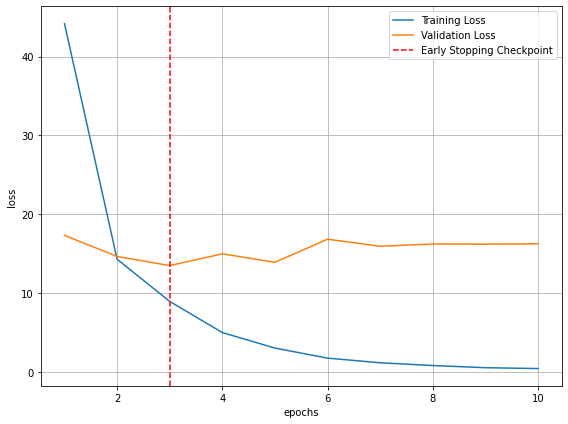

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.plot(range(1, len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
plt.plot(range(1, len(avg_valid_losses)+1), avg_valid_losses, label='Validation Loss')

#find the position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1
plt.axvline(minposs, linestyle='--', color = 'r', label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [21]:
torch.save(model, open("./checkpoints/job_fine_tuned_bert.bin", "wb"))

In [80]:
test_data = pd.read_table('./data/cls_datasets/cnews.test.txt', encoding='utf-8', names=['label', 'text'])
test_data = test_data[['text', 'label']]
test_data.head()

,text,label
0,鲍勃库西奖归谁属？ NCAA最强控卫是坎巴还是弗神新浪体育讯如今，本赛季的NCAA进入到了末...,体育
1,麦基砍28+18+5却充满寂寞 纪录之夜他的痛阿联最懂新浪体育讯上天对每个人都是公平的，贾维...,体育
2,黄蜂vs湖人首发：科比冲击七连胜 火箭两旧将登场新浪体育讯北京时间3月28日，NBA常规赛洛...,体育
3,双面谢亚龙作秀终成做作 谁来为低劣行政能力埋单是谁任命了谢亚龙？谁放纵了谢亚龙？谁又该为谢亚...,体育
4,兔年首战山西换帅后有虎胆 张学文用乔丹名言励志今晚客场挑战浙江稠州银行队，是山西汾酒男篮的兔...,体育


In [81]:
le = LabelEncoder()
le.fit(test_data.label.tolist())
# 标签ID化
test_data['label_id'] = le.transform(test_data.label.tolist())
labels_data = test_data.groupby(['label', 'label_id']).count().reset_index()
labels_map = labels_data[['label', 'label_id']]
labels_map

,label,label_id
0,体育,0
1,娱乐,1
2,家居,2
3,房产,3
4,教育,4
5,时尚,5
6,时政,6
7,游戏,7
8,科技,8
9,财经,9


In [39]:
# 转换为tensor
test_data['label'] = le.transform(test_data.label.tolist())
test_seqs, test_seq_masks, test_seq_segments, test_labels = processor.get_input(
    dataset=test_data)
test_seqs = torch.tensor(test_seqs, dtype=torch.long)
test_seq_masks = torch.tensor(test_seq_masks, dtype = torch.long)
test_seq_segments = torch.tensor(test_seq_segments, dtype = torch.long)
test_labels = torch.tensor(test_labels, dtype = torch.long)
test_data = TensorDataset(test_seqs, test_seq_masks, test_seq_segments, test_labels)
test_dataloder = DataLoader(dataset= test_data, batch_size = 192)
# 用于存储预测标签与真实标签
true_labels = []
pred_labels = []
model.eval()
# 预测
with torch.no_grad():
    for batch_data in tqdm_notebook(test_dataloder, desc = 'TEST'):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data        
        logits = model(
            batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
        logits = logits.softmax(dim=1).argmax(dim = 1)
        pred_labels.append(logits.detach().cpu().numpy())
        true_labels.append(batch_labels.detach().cpu().numpy())
# 查看各个类别的准确率和召回率
result = classification_report(np.concatenate(true_labels), np.concatenate(pred_labels))
print(result)

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1000
           1       0.83      0.96      0.89      1000
           2       0.90      0.88      0.89      1000
           3       0.88      0.71      0.79      1000
           4       0.91      0.69      0.78      1000
           5       0.93      0.85      0.89      1000
           6       0.71      0.92      0.80      1000
           7       0.97      0.91      0.94      1000
           8       0.96      0.94      0.95      1000
           9       0.90      0.99      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [60]:
result = classification_report(np.concatenate(true_labels), np.concatenate(pred_labels))
print(result)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1000
           1       0.83      0.96      0.89      1000
           2       0.90      0.88      0.89      1000
           3       0.88      0.71      0.79      1000
           4       0.91      0.69      0.78      1000
           5       0.93      0.85      0.89      1000
           6       0.71      0.92      0.80      1000
           7       0.97      0.91      0.94      1000
           8       0.96      0.94      0.95      1000
           9       0.90      0.99      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [63]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['label_id'] = row_data[1].strip()
        row['precision'] = float(row_data[2])
        row['recall'] = float(row_data[3])
        row['f1_score'] = float(row_data[4])
        row['support'] = float(row_data[5])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    return df

resultdata = classification_report_csv(result)
resultdata['label_id'] = resultdata['label_id'].apply(lambda x: int(x))
labels_map['label_id'] = labels_map['label_id'].apply(lambda x: int(x))
result_report = pd.merge(resultdata, labels_map, on='label_id', how='left')
result_report = result_report[['label', 'label_id', 'precision', 'recall', 'f1_score', 'support']]
print(result_report)
result_report.to_excel('./checkpoints/classification_report.xlsx', index=None)

  label  label_id  precision  recall  f1_score  support
0    体育         0       0.92    1.00      0.96   1000.0
1    娱乐         1       0.83    0.96      0.89   1000.0
2    家居         2       0.90    0.88      0.89   1000.0
3    房产         3       0.88    0.71      0.79   1000.0
4    教育         4       0.91    0.69      0.78   1000.0
5    时尚         5       0.93    0.85      0.89   1000.0
6    时政         6       0.71    0.92      0.80   1000.0
7    游戏         7       0.97    0.91      0.94   1000.0
8    科技         8       0.96    0.94      0.95   1000.0
9    财经         9       0.90    0.99      0.94   1000.0


/root/miniconda3/envs/myconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [82]:
labels_dict = {}
for i in range(labels_map.shape[0]):
    labels_dict[str(labels_map.loc[i,'label_id'])] = labels_map.loc[i,'label']

In [83]:
labels_dict

{'0': '体育',
 '1': '娱乐',
 '2': '家居',
 '3': '房产',
 '4': '教育',
 '5': '时尚',
 '6': '时政',
 '7': '游戏',
 '8': '科技',
 '9': '财经'}

In [71]:
"""config class"""
class Config(object):
    def __init__(self):
        self.model_file = './checkpoints/job_fine_tuned_bert.bin'
        self.bert_file = './pretrained_models/chinese_wwm_ext_pytorch/'
        self.MAX_SEQ_LEN = 50
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def json_read(self):
        with open(self.jsonfile, 'r', encoding='utf-8') as f:
            dicdata = json.load(f)
        return dicdata

In [72]:
class DataPrecessForSingleSentence(object):
    """
    对文本进行处理
    """

    def __init__(self, bert_tokenizer, max_workers=10):
        """
        bert_tokenizer :分词器
        dataset        :包含列名为'text'与'label'的pandas dataframe
        """
        self.bert_tokenizer = bert_tokenizer
        # 创建多线程池
        self.pool = ThreadPoolExecutor(max_workers=max_workers)
        # 获取文本与标签

    def get_input(self, dataset, max_seq_len=30):
        sentences = dataset.iloc[:, 0].tolist()
        labels = dataset.iloc[:, 1].tolist()
        # 切词
        tokens_seq = list(
            self.pool.map(self.bert_tokenizer.tokenize, sentences))
        # 获取定长序列及其mask
        result = list(
            self.pool.map(self.trunate_and_pad, tokens_seq,
                          [max_seq_len] * len(tokens_seq)))
        seqs = [i[0] for i in result]
        seq_masks = [i[1] for i in result]
        seq_segments = [i[2] for i in result]
        return seqs, seq_masks, seq_segments, labels

    def trunate_and_pad(self, seq, max_seq_len):
        # 对超长序列进行截断
        if len(seq) > (max_seq_len - 2):
            seq = seq[0:(max_seq_len - 2)]
        # 分别在首尾拼接特殊符号
        seq = ['[CLS]'] + seq + ['[SEP]']
        # ID化
        seq = self.bert_tokenizer.convert_tokens_to_ids(seq)
        # 根据max_seq_len与seq的长度产生填充序列
        padding = [0] * (max_seq_len - len(seq))
        # 创建seq_mask
        seq_mask = [1] * len(seq) + padding
        # 创建seq_segment
        seq_segment = [0] * len(seq) + padding
        # 对seq拼接填充序列
        seq += padding
        assert len(seq) == max_seq_len
        assert len(seq_mask) == max_seq_len
        assert len(seq_segment) == max_seq_len
        return seq, seq_mask, seq_segment

    def single_sent_input(self, sent, device, max_len):
        token_seq = bert_tokenizer.tokenize(sent)
        test_seq, test_seq_mask, test_seq_segment = self.trunate_and_pad(seq=token_seq, max_seq_len=max_len)
        test_seq = torch.tensor([list(test_seq)], dtype=torch.long).to(device)
        test_seq_mask = torch.tensor([list(test_seq_mask)], dtype=torch.long).to(device)
        test_seq_segment = torch.tensor([list(test_seq_segment)], dtype=torch.long).to(device)
        return test_seq, test_seq_mask, test_seq_segment

In [73]:
class TextClassifier(Config):
    def __init__(self):
        super().__init__()

    def predict(self, text, dicdata, processor, model):
        test_seq, test_seq_mask, test_seq_segment = processor.single_sent_input(
            sent=text, device=self.device, max_len=self.MAX_SEQ_LEN)
        logits = model(test_seq, test_seq_mask, test_seq_segment, labels=None)
        logits = logits.softmax(dim=1).argmax(dim=1)
        pred_id = logits.detach().cpu().numpy()[0]
        result = dicdata[str(pred_id)]
        return result

In [75]:
config_data = Config()
device = config_data.device
bert_file = config_data.bert_file
finetune_file = config_data.model_file
bert_tokenizer = BertTokenizer.from_pretrained(bert_file, do_lower_case=False)
processor = DataPrecessForSingleSentence(bert_tokenizer)
model = torch.load(open(finetune_file, "rb"), map_location='cpu')
model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [85]:
#预测
text_clf = TextClassifier()
text_clf.predict("中国乒乓在中国体育中大放光彩", labels_dict, processor, model)

'体育'